<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RecSys/blob/main/Paul%20Himyak/main_08_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python3 -m pip install -q git+https://github.com/keras-team/keras-tuner.git
!python3 -m pip install -q autokeras

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 104.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import uuid
import re
import numpy as np
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import concatenate, Embedding, Conv1D, Input, Dense, Dropout, BatchNormalization, Flatten , SpatialDropout1D, Reshape, RepeatVector, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.losses as keras_losses
import tensorflow.keras.metrics as keras_metrics
from tensorflow.keras import utils
import tensorflow as tf
!pip install -q tensorflow-addons
import tensorflow_addons as tfad

import sklearn.metrics as skl_metrics

import autokeras as ak


import gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 35.9 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
dataset_url = "https://drive.google.com/uc?export=download&id=1ErXvN290PPthLGsb0ALpa_0aUDnvC0jg"
#dataset_url = "https://docs.google.com/spreadsheets/d/1ErXvN290PPthLGsb0ALpa_0aUDnvC0jg/edit?usp=share_link&ouid=113369956649761615778&rtpof=true&sd=true"
dataset_filename = "profpatolog_modified.xlsx"
#!wget -qc dataset_url -O dataset_filename
gdown.download(dataset_url, output=dataset_filename, quiet=True )


'profpatolog_modified.xlsx'

In [ ]:
df = pd.read_excel("profpatolog_modified.xlsx")


In [ ]:
del df['Unnamed: 0']

In [ ]:
FIELD_CLIENT_AGE = "КлиентВозраст"
FIELD_CLIENT_BIRTH_DAY = "КлиентДатаРождения"
FIELD_CLIENT_GENDER = "КлиентПол"
FIELD_CLIENT_GENDER_M = 0
FIELD_CLIENT_GENDER_F = 1
FIELD_CONCLUSION = "ЗаключениеМК"
FIELD_CONCLUSION_FIT = 1
FIELD_CONCLUSION_PART_FIT = 2
FIELD_CONCLUSION_NOT_FIT = 0

FIELD_DISPANSARY_GROUP = "ДиспансернаяГруппа"
FIELD_DISPANSARY_GROUP_I = 0
FIELD_DISPANSARY_GROUP_II = 1
FIELD_DISPANSARY_GROUP_III = 2
FIELD_DISPANSARY_GROUP_OTHER = 3

FIELD_HARMFUL_FACTORS = "ВредныеФакторы"


FIELD_NEW_AGE_CATEGORY = "ВозрастКатегория"
FIELD_NEW_MKBS = "mkbs"

FIELD_CLIENT_PROFESSION = "Профессия"
FIELD_NEW_CLIENT_PROFESSION = "Profession"
FIELD_NEW_CLIENT_ADDITIONS = "Дополнения сводные"
FIELD_NEW_CLIENT_DIAG = "Diagnoz"

In [ ]:
import re
#функция из названя столбца выделяет первое значение
def extract_specialist_from_column_name(string):
    # Выделить первую часть до символа `_`
    first_part = string.split("_")[0]

    # Разбить первую часть на слова по стилю CamelCase и исключить цифры
    words = re.findall('[A-ZА-ЯЁ][a-zа-яё]*', first_part)

    # Объединить слова в строку с пробелами
    result = ' '.join(words)

    return result
extract_specialist_from_column_name("ПсихиатрияНаркология1_ДиагнозПредставление1")

'Психиатрия Наркология'

In [ ]:
#функция объединения ячеек в одну удаляя ненужный символ и объединяя вместе с названиями колонок
def join_not_nan_columns(df, columns_filter, value_for_unset = None):
  if value_for_unset is not None:
    df.loc[:, columns_filter.columns] = df.loc[:, columns_filter.columns].replace(value_for_unset, np.nan)
  return df[columns_filter.columns].apply(lambda row: ",".join(f"{extract_specialist_from_column_name(column_name)} {value}" for column_name, value in zip(columns_filter.columns, row) if pd.notna(value)), axis=1)
  



In [ ]:
diag_filter = df.filter(regex="(?i)Диагноз\s?Представление")
df[FIELD_NEW_CLIENT_DIAG] =  join_not_nan_columns(df, diag_filter, value_for_unset="Общий медицинский осмотр")
#Удаляю ненужные колонки
df = df.drop(columns=diag_filter)

<ipython-input-8-15e3a35bde05>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, columns_filter.columns] = df.loc[:, columns_filter.columns].replace(value_for_unset, np.nan)


In [ ]:
additions_filter = df.filter(regex="(?i)Дополнение_Значение$")
df[FIELD_NEW_CLIENT_ADDITIONS] = join_not_nan_columns(df, additions_filter)
df = df.drop(columns=additions_filter)

In [ ]:
mkbs_filter = df.filter(regex="(?i)МКБ10")
df[FIELD_NEW_MKBS] = join_not_nan_columns(df, mkbs_filter, value_for_unset="Z00.0")
df = df.drop(columns=mkbs_filter)

<ipython-input-8-15e3a35bde05>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, columns_filter.columns] = df.loc[:, columns_filter.columns].replace(value_for_unset, np.nan)


In [ ]:
df 

,КлиентДатаРождения,КлиентПол,ЗаключениеМК,ДиспансернаяГруппа,ВредныеФакторы,Профессия,Diagnoz,Дополнения сводные,mkbs
0,1976-10-24,Женский,Годен,I,11.4,Ведущий специалист по организации обуения,,"Эндоскопия Дискинезия желчевыводящих путей ,Те...",
1,1987-11-18,Мужской,Годен,IIIа,4.2.5,Ведущий специалист,Терапия Гипертензивная [гипертоническая] болез...,Терапия В анамнезе ГБ,Терапия I11.9
2,1985-09-08,Мужской,ГоденСКоррекциейЗрения,II,4.2.5,Главный менеджер,Офтальмология Миопия,"Терапия карбомезипин,мексидол,Офтальмология но...",Офтальмология H52.1
3,1988-04-25,Мужской,Годен,I,11.1,Главный специалист,,Эндоскопия Патологии со стороны слизистой пище...,
4,1984-04-17,Мужской,ГоденСКоррекциейЗрения,II,11.1,Старший специалист,Офтальмология Астигматизм,"Эндоскопия Без патологии.,Офтальмология носит ...",Офтальмология H52.2
...,...,...,...,...,...,...,...,...,...
1973,1972-11-12,Мужской,NaN,NaN,6.1,Директор по строительству,,,
1974,1986-07-09,Мужской,NaN,NaN,6.1,Начальник производственно-технического отдела,,,
1975,1994-05-12,Мужской,NaN,NaN,"5.1,23",Помощник кладовщика,Стоматология Кариес дентина,Психиатрия Наркология Тесты на обобщение и иск...,Стоматология K02.1
1976,1972-04-17,Женский,NaN,NaN,23,Повар,Терапия Гипертензивная [гипертоническая] болез...,"Терапия Гипертоническая болезнь, принимает Амл...",Терапия I11.9


In [ ]:
from datetime import datetime
class MyUtils:
  conclusion_map = {FIELD_CONCLUSION_FIT:'Годен', FIELD_CONCLUSION_PART_FIT:"Частично годен", FIELD_CONCLUSION_NOT_FIT: 'Негоден'}
  @classmethod
  def conclusion_labels(cls):
    return  [cls.conclusion_map[k] for k in sorted(cls.conclusion_map)]

  @classmethod
  def resolve_conclusion_map(cls,x):
    return cls.conclusion_map[x]
  @staticmethod  
  # Определяем функцию для расчета возраста на основе даты
  def resolve_birthdate_to_age(date):
    current_year = pd.Timestamp.now().year
    age = current_year - date.year
    return age
  def resolve_genger(x):
    if x == 'Мужской':
        return FIELD_CLIENT_GENDER_M
    elif x == 'Женский':
        return FIELD_CLIENT_GENDER_F
    else:
        return None

  def resolve_conclusion_binary(arg):
    try:
      if "Годен" == arg:
        return FIELD_CONCLUSION_FIT
      else:
        return FIELD_CONCLUSION_NOT_FIT
    except (TypeError):
        return None
  def resolve_conclusion(arg):
    try:
      if "Годен" == arg:
        return FIELD_CONCLUSION_FIT
      elif "Негоден" in arg:
        return FIELD_CONCLUSION_NOT_FIT
      elif "Годен" in arg:
        return FIELD_CONCLUSION_PART_FIT
      else:
        return FIELD_CONCLUSION_NOT_FIT
    except (TypeError):
        return None
  def resolve_dispansary_group(arg):
    try:
      if arg == "I":
        return FIELD_DISPANSARY_GROUP_I
      elif arg == "II":
        return FIELD_DISPANSARY_GROUP_II
      elif "III" in arg :
        return FIELD_DISPANSARY_GROUP_III
      else:
        return FIELD_DISPANSARY_GROUP_OTHER
    except (TypeError):
        return None
  def resolve_age_to_category(arg):
    outClass =int((arg-13)/5)
    outClass = max(0, min(10,outClass))
    return outClass

In [ ]:
# Преобразование заключения в цифру
df[FIELD_CONCLUSION] = df[FIELD_CONCLUSION].apply(lambda x: MyUtils.resolve_conclusion(x))

In [ ]:
# Преобразование колонки возраста в цифровой вид
df[FIELD_CLIENT_AGE] = df[FIELD_CLIENT_BIRTH_DAY].apply(MyUtils.resolve_birthdate_to_age)

# разделение возраста на категории
df[FIELD_NEW_AGE_CATEGORY] = df[FIELD_CLIENT_AGE].apply(MyUtils.resolve_age_to_category)

# Пол в цифру
df[FIELD_CLIENT_GENDER] = df[FIELD_CLIENT_GENDER].apply(lambda x: MyUtils.resolve_genger(x) if pd.notnull(x) else x)

# Удалим неиспользованные колонки
del df[FIELD_CLIENT_BIRTH_DAY]
del  df[FIELD_CLIENT_AGE]

In [ ]:
#Преобразование диспансерных групп в цифру
df[FIELD_DISPANSARY_GROUP] = df[FIELD_DISPANSARY_GROUP].apply(MyUtils.resolve_dispansary_group)

In [ ]:
# разделяем факторы по одному значению
df[FIELD_HARMFUL_FACTORS] = df[FIELD_HARMFUL_FACTORS].str.split(",")

In [ ]:
df.dropna(inplace = True)

Подготавливаю все однозначные цифровые данные в OHE

In [ ]:
# Объединяю категориальные значения в OHE
df_ohe  = pd.get_dummies(df[[FIELD_CLIENT_GENDER, FIELD_DISPANSARY_GROUP, FIELD_NEW_AGE_CATEGORY]],  columns = [FIELD_CLIENT_GENDER, FIELD_DISPANSARY_GROUP, FIELD_NEW_AGE_CATEGORY] )
xTrain0 = df_ohe.values
xTrain0.shape


(1562, 16)

In [ ]:
yTrain =  pd.get_dummies(df[FIELD_CONCLUSION]).values

In [ ]:
Y_CLASSES = yTrain.shape[1]
Y_CLASSES

3

Токенизируем наши поля

Это моя обертка над токенизатором, для удобства использования для повторяющейся задачи

In [ ]:
np_len = np.vectorize(len)


class MySequences:
  value = None
  max_len = None
  def get_padded(self):
    return pad_sequences(self.value, maxlen=self.max_len, padding='post')


class MyTokenizer:
  tokenizer:Tokenizer
  _indexed = None
  def __init__(self, *tokenizer_args, **tokenizer_kwargs):
    self.tokenizer = Tokenizer(*tokenizer_args, **tokenizer_kwargs)
    
  @property
  def vocab_size(self):
    return len(self.tokenizer.word_index) + 1
 
  def fit_on_texts(self, series):
    self.tokenizer.fit_on_texts(series)
 
  def texts_to_sequences(self, series):
    
    self._indexed = MySequences()


    self._indexed.value = self.tokenizer.texts_to_sequences(series)
    self._indexed.max_len = np_len(self._indexed.value).max()
    return self._indexed
  
  def process_data(self, series):
    self.fit_on_texts(series)
    self.texts_to_sequences(series)
  
  @property
  def indexed(self)->MySequences:
    return self._indexed

  def __call__(self):
    return self.tokenizer

In [40]:
df

,КлиентПол,ЗаключениеМК,ДиспансернаяГруппа,ВредныеФакторы,Профессия,Diagnoz,Дополнения сводные,mkbs,ВозрастКатегория
0,1,1.0,0.0,[11.4],Ведущий специалист по организации обуения,,"Эндоскопия Дискинезия желчевыводящих путей ,Те...",,6
1,0,1.0,2.0,[4.2.5],Ведущий специалист,Терапия Гипертензивная [гипертоническая] болез...,Терапия В анамнезе ГБ,Терапия I11.9,4
2,0,2.0,1.0,[4.2.5],Главный менеджер,Офтальмология Миопия,"Терапия карбомезипин,мексидол,Офтальмология но...",Офтальмология H52.1,5
3,0,1.0,0.0,[11.1],Главный специалист,,Эндоскопия Патологии со стороны слизистой пище...,,4
4,0,2.0,1.0,[11.1],Старший специалист,Офтальмология Астигматизм,"Эндоскопия Без патологии.,Офтальмология носит ...",Офтальмология H52.2,5
...,...,...,...,...,...,...,...,...,...
1956,0,1.0,1.0,"[4.4, 4.5, 6.1]",Инженер,Офтальмология Миопия,"Офтальмология 1,0,Офтальмология -0,75 -0,50/-0,50",Офтальмология H52.1,4
1957,0,1.0,0.0,"[4.4, 4.5, 6.1]",Инженер,,,,3
1958,0,1.0,0.0,[4.4],Начальник лаборатории,,,,4
1968,0,1.0,0.0,[3.1.8.2],"Инженер по бурению 1 категории, непосредственн...",,,,4


In [41]:
df[[FIELD_NEW_AGE_CATEGORY, FIELD_CLIENT_GENDER, FIELD_DISPANSARY_GROUP]]


,ВозрастКатегория,КлиентПол,ДиспансернаяГруппа
0,6,1,0.0
1,4,0,2.0
2,5,0,1.0
3,4,0,0.0
4,5,0,1.0
...,...,...,...
1956,4,0,1.0
1957,3,0,0.0
1958,4,0,0.0
1968,4,0,0.0


In [42]:
df[[FIELD_CLIENT_PROFESSION]]

,Профессия
0,Ведущий специалист по организации обуения
1,Ведущий специалист
2,Главный менеджер
3,Главный специалист
4,Старший специалист
...,...
1956,Инженер
1957,Инженер
1958,Начальник лаборатории
1968,"Инженер по бурению 1 категории, непосредственн..."


In [ ]:
df[FIELD_NEW_CLIENT_ADDITIONS]

0       Эндоскопия Дискинезия желчевыводящих путей ,Те...
1                                   Терапия В анамнезе ГБ
2       Терапия карбомезипин,мексидол,Офтальмология но...
3       Эндоскопия Патологии со стороны слизистой пище...
4       Эндоскопия Без патологии.,Офтальмология носит ...
                              ...                        
1956    Офтальмология 1,0,Офтальмология -0,75 -0,50/-0,50
1957                                                     
1958                                                     
1968                                                     
1969    Офтальмология 2019г Лазик (-3.0),Психиатрия На...
Name: Дополнения сводные, Length: 1562, dtype: object

In [ ]:
df[FIELD_HARMFUL_FACTORS]

0                [11.4]
1               [4.2.5]
2               [4.2.5]
3                [11.1]
4                [11.1]
             ...       
1956    [4.4, 4.5, 6.1]
1957    [4.4, 4.5, 6.1]
1958              [4.4]
1968          [3.1.8.2]
1969       [4.2.5, 6.1]
Name: ВредныеФакторы, Length: 1562, dtype: object

In [59]:
f1score = tfad.metrics.F1Score(num_classes=Y_CLASSES)


In [69]:
from sys import meta_path
# создаем входной узел для структурированных данных
x_base_input = ak.StructuredDataInput(name = 'base')
x_base_output = ak.StructuredDataBlock()(x_base_input)

# создаем входной узел для текстовых данных
x_prof_input = ak.TextInput(name="prof")
x_prof_output = ak.TextToIntSequence()(x_prof_input)
x_prof_output = ak.Embedding()(x_prof_output)
x_prof_output = ak.ConvBlock(separable=True)(x_prof_output)

x_harm_input = ak.TextInput(name="harm")
x_harm_output = ak.TextToIntSequence()(x_harm_input)
x_harm_output = ak.Embedding()(x_harm_output)
x_harm_output = ak.ConvBlock(separable=True)(x_harm_output)

x_additions_input = ak.TextInput(name="additions")
x_additions_output = ak.TextToIntSequence()(x_additions_input)
x_additions_output = ak.Embedding()(x_additions_output)
x_additions_output = ak.ConvBlock(separable=True)(x_additions_output)


x_diags_input = ak.TextInput(name="diags")
x_diags_output = ak.TextToIntSequence()(x_diags_input)
x_diags_output = ak.Embedding()(x_diags_output)
x_diags_output = ak.ConvBlock(separable=True)(x_diags_output)
# объединяем оба выхода
merged_output = ak.Merge()([x_base_output, 
                            x_prof_output, 
                            #x_harm_output, 
                            x_additions_output,
                            x_diags_output
                            ])

# добавляем выходной узел для классификации
output_node = ak.ClassificationHead(num_classes=3)(merged_output)

# создаем и обучаем автомодель
auto_model = ak.AutoModel(
    inputs=[
      x_base_input,
      x_prof_input,
      #x_harm_input,
      x_additions_input,
      x_diags_input     
      ], 
    outputs=output_node, 
    overwrite=True, 
    max_trials=3,
    #metrics=[keras_metrics.mae, f1score]
)


history = auto_model.fit([
      df[[FIELD_NEW_AGE_CATEGORY, FIELD_CLIENT_GENDER, FIELD_DISPANSARY_GROUP]],
      df[FIELD_CLIENT_PROFESSION].to_numpy(),
      #df[FIELD_HARMFUL_FACTORS].to_numpy(),
      df[[FIELD_NEW_CLIENT_ADDITIONS]].to_numpy(),
      df[[FIELD_NEW_CLIENT_DIAG]].to_numpy()
    ]
    , yTrain, 
    epochs=10,
    validation_split=0.3
    )


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
False             |False             |structured_data_block_1/normalize
False             |False             |structured_data_block_1/dense_block_1/use_batchnorm
2                 |2                 |structured_data_block_1/dense_block_1/num_layers
32                |32                |structured_data_block_1/dense_block_1/units_0
0                 |0                 |structured_data_block_1/dense_block_1/dropout
32                |32                |structured_data_block_1/dense_block_1/units_1
64                |64                |text_to_int_sequence_1/output_sequence_length
64                |64                |text_to_int_sequence_3/output_sequence_length
64                |64                |text_to_int_sequence_4/output_sequence_length
none              |none              |embedding_1/pretraining
128               |128               |embedding_1/embedding_dim
0.25              |0.25              |emb

KeyboardInterrupt: ignored

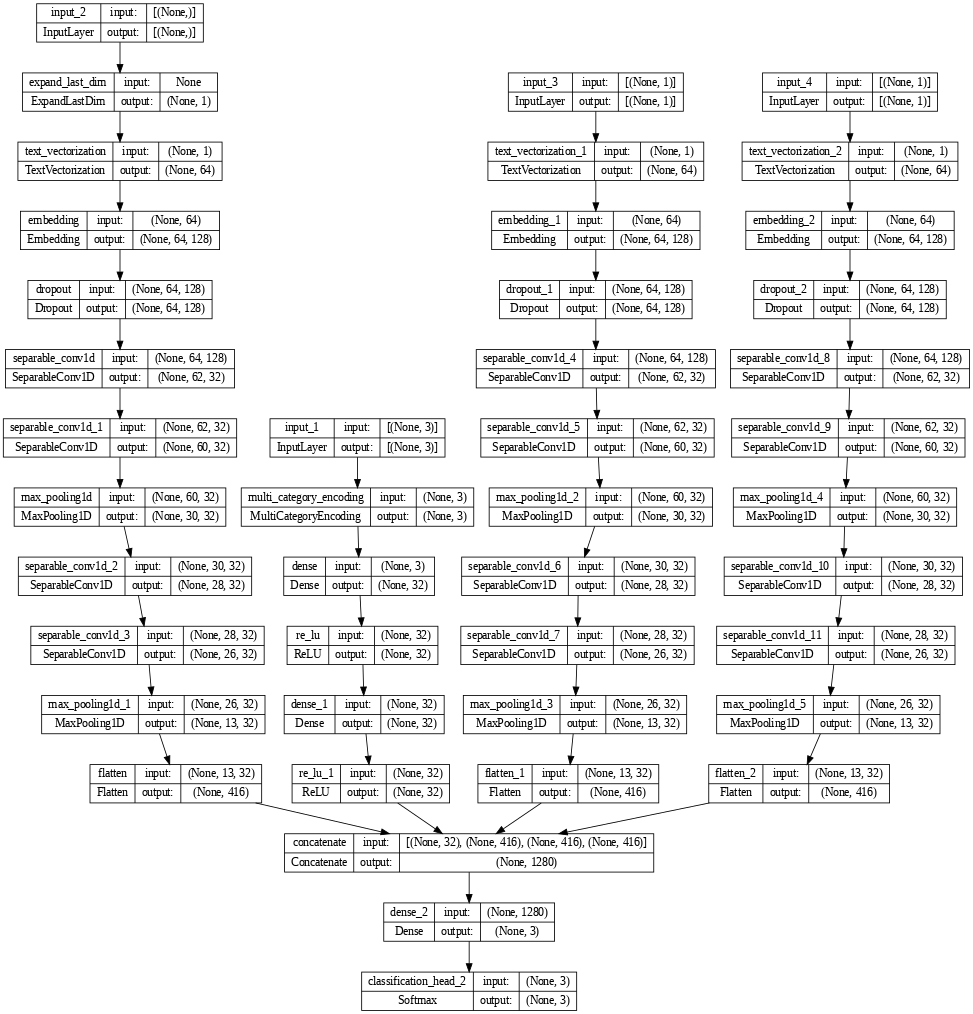

In [58]:
best_model = auto_model.export_model()
utils.plot_model(best_model, dpi=60, show_shapes = True)


In [61]:
# Визуальная оценка ошибки на обучающей и проверочной выборках

def compare_sharp_loss (history, x_size, y_size):
  
  plt.figure(figsize=(x_size,y_size))
  plt.plot(history.history['loss'], 
         label='Ошибка на обучающей выборке')
  
  plt.plot(history.history['val_loss'], 
         label='Ошибка проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Средняя ошибка')
  plt.legend()
  plt.show()

KeyError: ignored

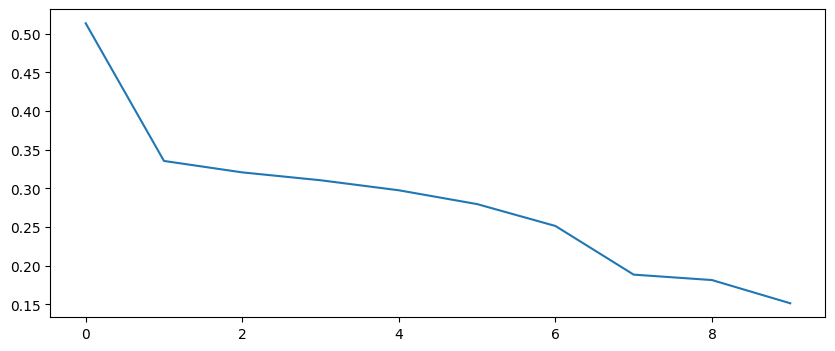

In [62]:
compare_sharp_loss(history, 10, 4)

In [63]:

train_f1scores = np.array(history.history['f1_score'])
val_f1scores = np.array(history.history['val_f1_score'])
plt.figure(figsize=(10,5))

for class_idx in range(Y_CLASSES):
    color = f'C{class_idx}'
    plt.plot(train_f1scores[:, class_idx], color=color, linestyle = '-', label=f'Training (Class {MyUtils.conclusion_map[class_idx]})')
    plt.plot(val_f1scores[:, class_idx], color=color, linestyle = '--',label=f'Validation (Class {MyUtils.conclusion_map[class_idx]})')

plt.legend(fontsize='small')

plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя f1score')

#plt.title("Training and Validation F1 Score by Class")

plt.show()

KeyError: ignored